# ProgPy Tutorial
_2024 PHM Society Conference_

_November, 2024_

Please put questions in the Whova App or raise your hand.

# Pre-Work
_We recommend installing ProgPy prior to the tutorial_

The latest stable release of ProgPy is hosted on PyPi. To install via the command line, use the following command: 

`$ pip install progpy`

The documentation for ProgPy can be found [here](https://nasa.github.io/progpy/index.html). We will reference this material throughout the tutorial. ProgPy can be found on GitHub at [this link](https://github.com/nasa/progpy).

Please download the Whova App (<span style="color:red"> link? </span>) for live Q&A during the session.

Next, lets download the data we will be using for this tutorial. To do this we will use the datasets subpackage in progpy.

In [1]:
from progpy.datasets import nasa_battery
(desc, data) = nasa_battery.load_data(1)

/Users/kjgriff2/venv/ProgPyEnv1/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Introduction to ProgPy

NASA’s ProgPy is an open-source python package supporting research and development of prognostics, health management, and predictive maintenance tools. It implements architectures and common functionality of prognostics, supporting researchers and practitioners.

The goal of this tutorial is to instruct users how to use and extend ProgPy. This tutorial will cover how to use a model, including existing models and additional capabilities like parameter estimation and simulation, as well as how to build a new model from scratch. 

### Definitions and Background



The tutorial will begin with an introduction to prognostics and ProgPy using ProgPy's documentation. Please follow along in the [ProgPy Guide](https://nasa.github.io/progpy/guide.html).

### Tutorial Outline

0. The Dataset 

1. Using an existing model
    - Loading a model
    - Model parameters
    - Simulation
    - Noise
    - Prognostics with data
    - Data-driven capabilities and surrogate models

2. Building a new model 
    - State transition 
    - Outputs
    - Events
    - Using the model
    - Parameter estimation
    - Prognostics example
    - Final notes 

3. Advanced Capabilities
    - Combination models 
 
<span style="color:red"> update this as we go along ... </span>


# The Dataset

Let's prepare the dataset that we will use for this tutorial.

In [2]:
print(desc['description'])

Experiment consisting of repeated iteration of a randomized series of discharging pulses followed by a recharging period of variable length. Batteries are charged and discharged at room temperature


The dataset includes a number of different runs. Let's take a look at the first 10 as a starting point

In [3]:
print(desc['runs'][:10])

[{'type': 'D', 'desc': 'low current discharge at 0.04A', 'date': '30-Dec-2013 15:53:29'}, {'type': 'C', 'desc': 'low current charge', 'date': '01-Jan-2014 20:23:07'}, {'type': 'C', 'desc': 'reference charge', 'date': '04-Jan-2014 01:30:58'}, {'type': 'D', 'desc': 'reference discharge', 'date': '04-Jan-2014 02:28:25'}, {'type': 'C', 'desc': 'reference charge', 'date': '04-Jan-2014 04:28:28'}, {'type': 'D', 'desc': 'reference discharge', 'date': '04-Jan-2014 08:06:47'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 13:43:19'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 14:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 14:13:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 14:33:20'}]


This includes runs from multiple discharges at different kinds. Let's take a look at the trickle discharge run first

       relativeTime  current  voltage  temperature
0              0.15    0.018    4.196     18.37451
1             10.15    0.040    4.192     18.37451
2             20.15    0.040    4.191     18.37451
3             30.15    0.040    4.191     18.37451
4             40.15    0.040    4.190     18.39025
...             ...      ...      ...          ...
18894     188940.15    0.040    3.206     17.88630
18895     188950.15    0.040    3.204     17.88630
18896     188960.15    0.039    3.203     17.88630
18897     188970.15    0.040    3.201     17.88630
18898     188976.68    0.040    3.200     17.88630

[18899 rows x 4 columns]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

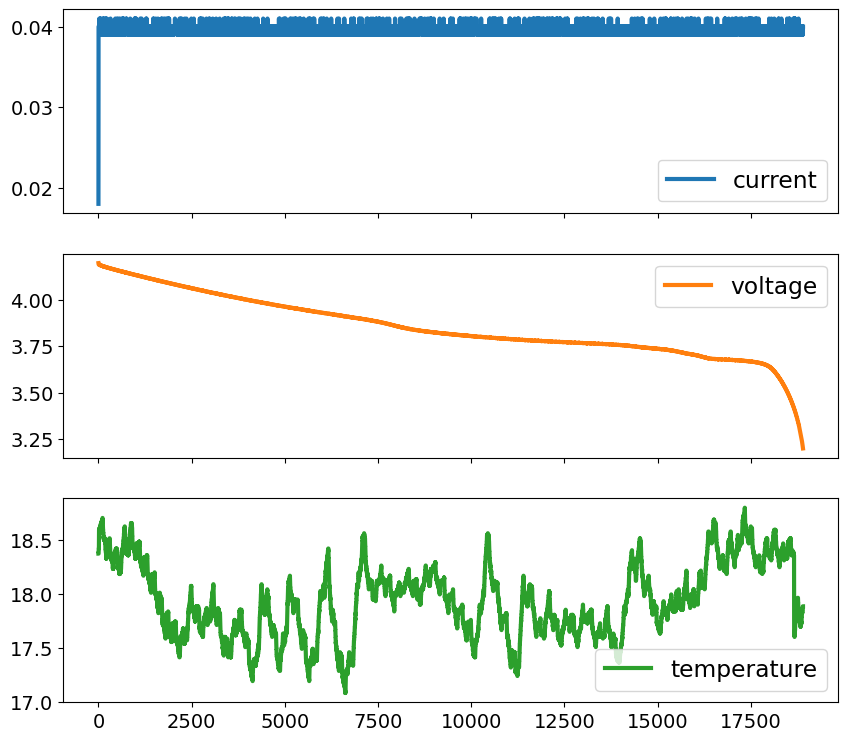

In [4]:
trickle_dataset = data[0]
print(trickle_dataset)
trickle_dataset.plot(y=['current', 'voltage', 'temperature'], subplots=True)

Now let's do the same for a reference discharge run (5)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

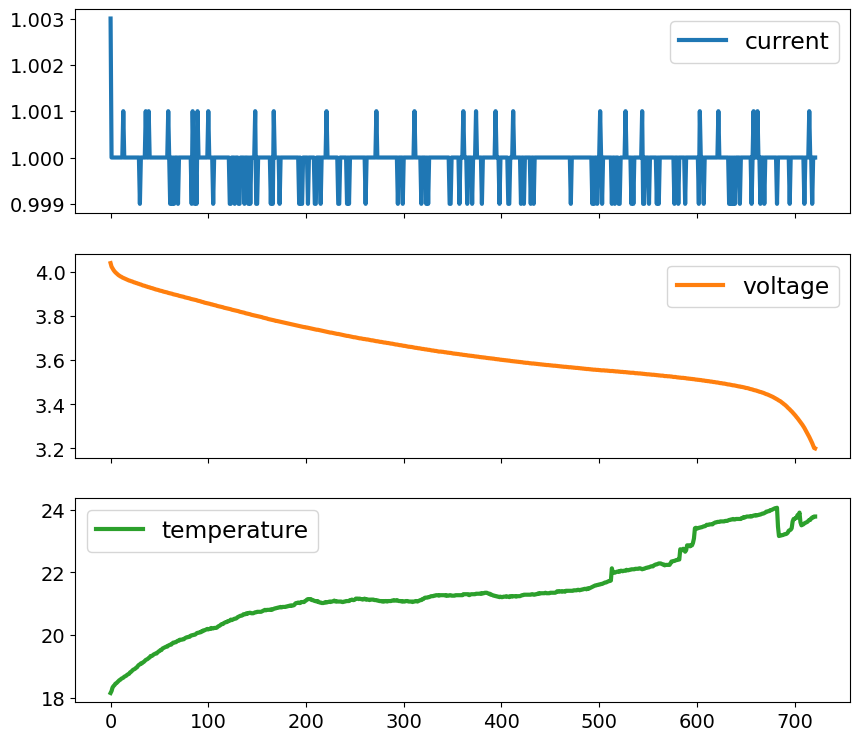

In [5]:
reference_dataset = data[5]
reference_dataset.plot(y=['current', 'voltage', 'temperature'], subplots=True)

Now let's take a look at one of the step discharges. This actually includes multiple runs

In [6]:
print(desc['runs'][7:35])

[{'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 14:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 14:13:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 14:33:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 14:43:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 15:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 15:13:19'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 15:33:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 15:43:19'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 16:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 16:13:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 16:33:19'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 16:43:20'}, {'type': 'D', 'desc': 'pulsed load (discharge

Includes a charge, which we dont want to include in our characterization. So we should treat that as a different run.

relativeTime resets for each "run". So if we're going to use multiple runs together, we need to stitch these times together.

In [7]:
data[7]['absoluteTime'] = data[7]['relativeTime']
for i in range(8, 32):
    data[i]['absoluteTime'] = data[i]['relativeTime'] + data[i-1]['absoluteTime'].iloc[-1]

Next we should combine the data into a single dataset and investigate the results

       relativeTime  current  voltage  temperature  absoluteTime
0              0.04    1.006    4.038     18.24852          0.04
1              1.04    1.000    4.035     18.24852          1.04
2              2.04    1.000    4.033     18.24852          2.04
3              3.04    1.000    4.032     18.23277          3.04
4              4.04    1.001    4.030     18.24852          4.04
...             ...      ...      ...          ...           ...
21736        112.04    1.000    3.207     19.90211      21712.04
21737        113.04    1.000    3.205     19.91786      21713.04
21738        114.04    1.000    3.202     19.91786      21714.04
21739        115.04    1.000    3.200     19.91786      21715.04
21740        115.08    1.000    3.200     19.91786      21715.08

[21741 rows x 5 columns]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

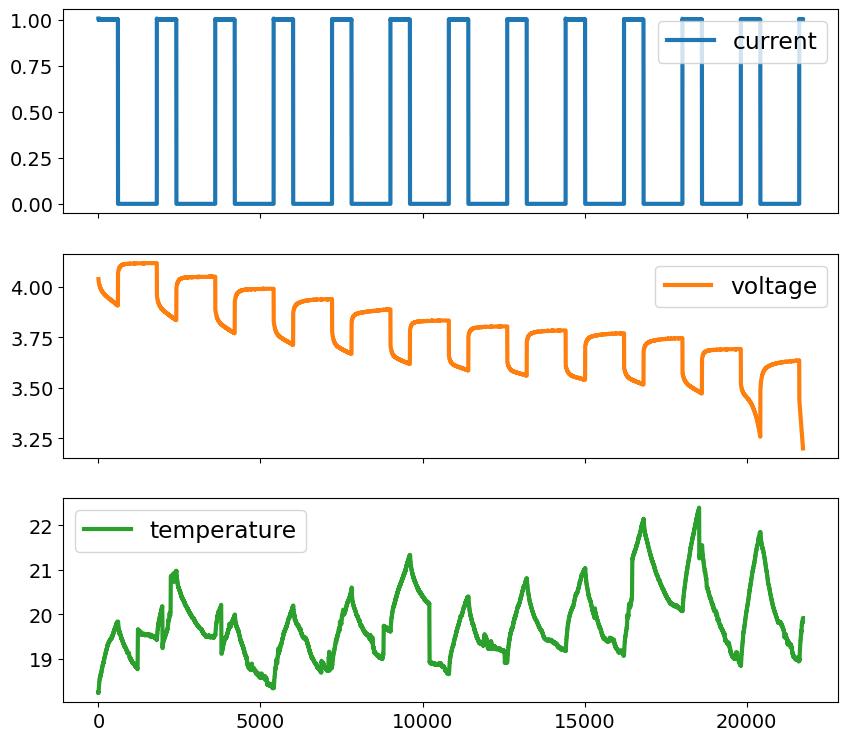

In [8]:
import pandas as pd
step_dataset = pd.concat(data[7:32], ignore_index=True)
print(step_dataset)
step_dataset.plot(y=['current', 'voltage', 'temperature'], subplots=True)

Finally, let's investigate the random walk discharge

In [9]:
print(desc['runs'][35:50])

[{'type': 'R', 'desc': 'rest (random walk)', 'date': '04-Jan-2014 23:49:02'}, {'type': 'D', 'desc': 'discharge (random walk)', 'date': '04-Jan-2014 23:49:04'}, {'type': 'R', 'desc': 'rest (random walk)', 'date': '04-Jan-2014 23:54:03'}, {'type': 'D', 'desc': 'discharge (random walk)', 'date': '04-Jan-2014 23:54:04'}, {'type': 'R', 'desc': 'rest (random walk)', 'date': '04-Jan-2014 23:59:04'}, {'type': 'D', 'desc': 'discharge (random walk)', 'date': '04-Jan-2014 23:59:05'}, {'type': 'R', 'desc': 'rest (random walk)', 'date': '05-Jan-2014 00:04:05'}, {'type': 'D', 'desc': 'discharge (random walk)', 'date': '05-Jan-2014 00:04:05'}, {'type': 'R', 'desc': 'rest (random walk)', 'date': '05-Jan-2014 00:09:05'}, {'type': 'D', 'desc': 'discharge (random walk)', 'date': '05-Jan-2014 00:09:05'}, {'type': 'R', 'desc': 'rest (random walk)', 'date': '05-Jan-2014 00:14:05'}, {'type': 'D', 'desc': 'discharge (random walk)', 'date': '05-Jan-2014 00:14:05'}, {'type': 'R', 'desc': 'rest (random walk)', '

Like the step discharge, we need to stitch together the times and concatenate the data

In [10]:
data[35]['absoluteTime'] = data[35]['relativeTime']
for i in range(36, 50):
    data[i]['absoluteTime'] = data[i]['relativeTime'] + data[i-1]['absoluteTime'].iloc[-1]

      relativeTime  current  voltage  temperature  absoluteTime
0             0.01    0.000    4.198     19.44540          0.01
1             0.99    0.000    4.198     19.44540          0.99
2             0.04    4.003    3.589     19.44540          1.03
3             1.04    3.999    3.663     19.44540          2.03
4             2.04    4.000    3.673     19.46115          3.03
...            ...      ...      ...          ...           ...
1818          0.01    0.000    3.672     36.67751       1803.33
1819          0.24    0.000    3.679     36.67751       1803.56
1820          0.01    3.883    3.117     36.67751       1803.57
1821          0.01    0.000    3.675     36.67751       1803.58
1822          5.00    0.000    3.699     36.58487       1808.57

[1823 rows x 5 columns]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

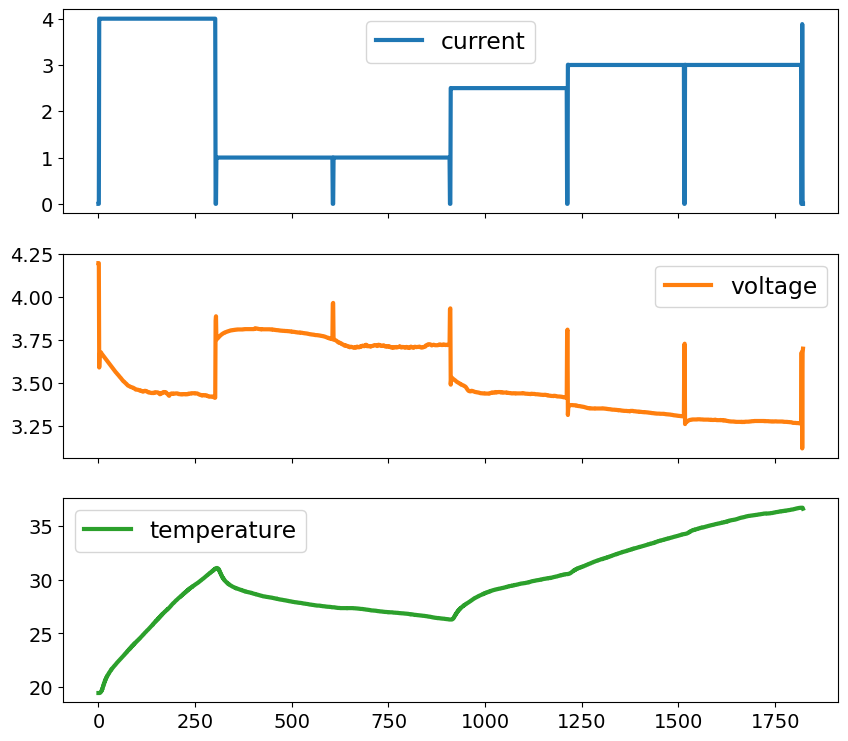

In [11]:
random_walk_dataset = pd.concat(data[35:50], ignore_index=True)
print(random_walk_dataset)
random_walk_dataset.plot(y=['current', 'voltage', 'temperature'], subplots=True)

Now the data is ready for this tutorial, let's dive into it.

# Using an existing Model

The first component of ProgPy are the **Prognostics Models**. Models describe the behavior of the system of interest and how the state of the system evolves with use. ProgPy includes capability for prognostics models to be [physics-based](https://nasa.github.io/progpy/glossary.html#term-physics-based-model) or [data-driven](https://nasa.github.io/progpy/glossary.html#term-data-driven-model).

All prognostics models have the same [format](https://nasa.github.io/progpy/prog_models_guide.html#progpy-prognostic-model-format) within ProgPy. The architecture requires definition of model inputs, states, outputs, and events which come together to create a system model.

ProgPy includes a collection of [included models](https://nasa.github.io/progpy/api_ref/progpy/IncludedModels.html#included-models) which can be accessed through the `progpy.models` package.


### Loading a Model

To illustrate how to use a built-in model, let's use the [Battery Electrochemistry model](https://nasa.github.io/progpy/api_ref/progpy/IncludedModels.html#:~:text=class%20progpy.models.BatteryElectroChemEOD(**kwargs)). This model predicts the end-of-discharge of a Lithium-ion battery based on a set of differential equations that describe the electrochemistry of the system [Daigle et al. 2013](https://papers.phmsociety.org/index.php/phmconf/article/view/2252).



First, import the model from the `progpy.models` package.

In [ ]:
from progpy.models import BatteryElectroChemEOD

Next, let's create a new battery using the default settings:

In [ ]:
batt = BatteryElectroChemEOD()

### Model parameters

Model parameters describe the specific system the model will simulate. For the Electrochemistry model, the default model parameters are for 18650-type Li-ion battery cells. All parameters can be accessed through `batt.parameters`. Let's print out all of the parameters, followed by the specific parameter for the battery's capacity, denoted as `qMax` in this model.

In [ ]:
print(batt.parameters)
print(batt['qMax'])

Parameter values can be configured in various ways. Parameter values can be passed into the constructor as keyword arguments when the model is first instantiated or can be set afterwards, like so:

In [ ]:
batt['qMax'] = 127000
print(batt['qMax'])

In addition to setting model parameter values by hand, ProgPy includes a [parameter estimation](https://nasa.github.io/progpy/prog_models_guide.html#parameter-estimation:~:text=examples.future_loading-,Parameter%20Estimation,-%23) functionality that tunes the parameters of a general model to match the behavior of a specific system. In ProgPy, the `progpy.PrognosticsModel.estimate_params()` method tunes model parameters so that the model provides a good fit to observed data. In the case of the Electrochemistry model, for example, parameter estimation would take the general battery model and configure it so that it more accurately describes a specific battery. The ProgPy documentation includes a [detailed example](https://nasa.github.io/progpy/prog_models_guide.html#parameter-estimation:~:text=See%20the%20example%20below%20for%20more%20details) on how to do parameter estimation.

### Simulation

Once a model has been created, the next step is to simulate it's evolution throughout time. Simulation is the foundation of prediction, but unlike full prediction, simulation does not include uncertainty in the state and other product (e.g., [output](https://nasa.github.io/progpy/glossary.html#term-output)) representation.

*Future Loading*

Most prognostics models have some sort of [input](https://nasa.github.io/progpy/glossary.html#term-input), i.e. a control or load applied to the system that impacts the system state and outputs. For example, for a battery, the current drawn from the battery is the applied load, or input. In this case, to simulate the system, we must define a `future_loading` function that describes how the system will be loaded, or used, throughout time. (Note that not all systems have applied load, e.g. [ThrowObject](https://nasa.github.io/progpy/api_ref/progpy/IncludedModels.html?highlight=thrownobject#progpy.models.ThrownObject), and no `future_loading` is required in these cases.)

ProgPy includes pre-defined [loading functions](https://nasa.github.io/progpy/api_ref/progpy/Loading.html?highlight=progpy%20loading) in `progpy.loading`. Here, we'll implement the built-in piecewise loading functionality. <span style="color:red"> do we want more description of this or just verbal? </span>

In [ ]:
from progpy.loading import Piecewise

future_loading = Piecewise(
        InputContainer=batt.InputContainer,
        times=[600, 900, 1800, 3000],
        values={'i': [2, 1, 4, 2, 3]})

*Simulate to Threshold*

With this in mind, we're ready to simulate our model forward in time using ProgPy's [simulation functionality](https://nasa.github.io/progpy/prog_models_guide.html#simulation).

Physical systems frequently have one or more failure modes, and there's often a need to predict the progress towards these events and the eventual failure of the system. ProgPy generalizes this concept of predicting Remaining Useful Life (RUL) with [events](https://nasa.github.io/progpy/prog_models_guide.html#events) and their corresponding thresholds at which they occur. 


Often, there is interest in simulating a system forward in time until a particular event occurs. ProgPy includes this capability with `simulate_to_threshold()`. 

First, let's take a look at what events exist for the Electrochemistry model.

In [ ]:
batt.events

The only event in this model is 'EOD' or end-of-discharge. The `progpy.PrognosticsModel.event_state()` method estimates the progress towards the event, with 1 representing no progress towards the event and 0 indicating the event has occurred.  The method `progpy.PrognosticsModel.threshold_met()` defines when the event has happened. In the Electrochemistry model, this occurs when the battery voltage drops below some pre-defined value, which is stored in the parameter `VEOD`. Let's see what this threshold value is.

In [ ]:
batt.parameters['VEOD']

With these definitions in mind, let's simulate the battery model until threshold for EOD is met. We'll use the same `future_loading` function as above. 

In [ ]:
options = { #configuration for this sim
    'save_freq': 100,  # Frequency at which results are saved (s)
    'horizon': 8000  # Maximum time to simulate (s) - This is a cutoff. The simulation will end at this time, or when a threshold has been met, whichever is first
    }
results = batt.simulate_to_threshold(future_loading, **options)

Let's visualize the results. Note that the simulation ends when the voltage value hits the VEOD value of 3.0.

In [ ]:
results.inputs.plot(ylabel='Current drawn (amps)')
results.event_states.plot(ylabel='Battery State of Charge')
results.outputs.plot(ylabel= {'v': "voltage (V)", 't': 'temperature (°C)'}, compact= False)

In addition to simulating to threshold, ProgPy also includes a simpler capability to simulate until a particular time, using `simulate_to()`.

### Noise

A key factor in modeling any real-world application is noise. See the ProgPy [noise documentation](https://nasa.github.io/progpy/prog_models_guide.html#noise) for a detailed description of different types of noise and how to include it in the ProgPy architecture. 

### Prognostics with data



Now that we have a basic simulation of our model, let's make a prediction using the prognostics capabilities within ProgPy. The two basic components of prognostics are [state estimation and prediction](https://nasa.github.io/progpy/prog_algs_guide.html#state-estimation-and-prediction-guide). ProgPy includes functionality to do both. 

To implement a prognostics example, we first need data from our system. We'll use the data we've already uploaded and prepped above.

For the battery electrochemistry model, we'll need to use a [state estimator](https://nasa.github.io/progpy/prog_algs_guide.html#state-estimation) because the model state is not directly measureable, i.e. it has hidden states. We'll use an Unscented Kalman filter and the `estimate` method. ProgPy also includes a Particle Filter and a Kalman Filter.  

First, let's load the necessary imports.

In [ ]:
import numpy as np
from progpy.state_estimators import UnscentedKalmanFilter
from progpy.uncertain_data import MultivariateNormalDist

State estimators require an initial state. To define this, we'll first initialize the model and then define the initial state as a distribution of possible states around this using a multi-variate normal distribution. 

In [ ]:
initial_state = batt.initialize() # Initialize model
x_guess = MultivariateNormalDist(initial_state.keys(), initial_state.values(), np.diag([max(x_i*0.1, 0.1) for x_i in initial_state.values()])) # Define distribution around initial state

With our initial distribution defined, we can now instantiate the state estimator.

In [ ]:
ukf = UnscentedKalmanFilter(batt, x_guess)

With this, we're ready to run the Unscented Kalman Filter. To illustrate how state estimation works, let's estimate one step forward in time. First, we'll extract the measurement at this time. 

In [ ]:
# Define time step based on data
dt = random_walk_dataset['absoluteTime'][1] - random_walk_dataset['absoluteTime'][0]

# Data at time point
z = {'t': random_walk_dataset['temperature'][1], 'v': random_walk_dataset['voltage'][1]}

Next, we'll estimate the new state by calling the `estimate` method. 

In [ ]:
# Extract input current from data 
i = {'i': random_walk_dataset['current'][1]}

# Estimate the new state
ukf.estimate(dt, i, z)
x_est = ukf.x.mean

Finally, let's look at the difference between the estimated state and the true measurement. In the following plots, blue circles represent the initial distribution and orange circles represent the estimated result. The orange circles are more refined and give a better estimate, highlighting the usefulness of the state estimator.

In [ ]:
fig = x_guess.plot_scatter(label='initial')
fig = ukf.x.plot_scatter(fig=fig, label='update')

Now that we know how to do state estimation, the next key component of prognostics is [prediction](https://nasa.github.io/progpy/prog_algs_guide.html#prediction). ProgPy includes multiple predictors, and we'll implement a Monte Carlo predictor here. Let's load the necessary imports. 

In [ ]:
from progpy.predictors import MonteCarlo

Next, let's add some [process and measurement noise](https://nasa.github.io/progpy/prog_models_guide.html?highlight=noise#noise) into our system, to capture any uncertainties. 

In [ ]:
PROCESS_NOISE = 5e-3            # Percentage process noise
MEASUREMENT_NOISE = 1e-4        # Percentage measurement noise

# Apply process noise to state
batt.parameters['process_noise'] = {key: PROCESS_NOISE * value for key, value in initial_state.items()}

# Apply measurement noise to output
z0 = batt.output(initial_state)
batt.parameters['measurement_noise'] = {key: MEASUREMENT_NOISE * value for key, value in z0.items()}

Next, let's set up our predictor. 

In [ ]:
mc = MonteCarlo(batt)

To perform the prediction, we need to specify a few things, including the number of samples we want to use for the prediction, the step size for the prediction, and the prediction horizon (i.e., the time value to predict to).

In [ ]:
NUM_SAMPLES = 100
STEP_SIZE = 1
PREDICTION_HORIZON = random_walk_dataset['absoluteTime'].iloc[-1] 

We also need to define a future loading function based on the load in the dataset we are using. Let's extract the necessary information and define a function.

In [ ]:
# Extract time and outputs from data
times_rw = random_walk_dataset['absoluteTime']
outputs_rw = [{'v': elem[1]['voltage']} for elem in random_walk_dataset.iterrows()]

# Define function
import numpy as np
def future_load_rw(t, x=None):
    current = np.interp(t, times_rw, random_walk_dataset['current'])
    return {'i': current}

With this, we are ready to predict. 

In [ ]:
mc_results = mc.predict(initial_state, future_loading_eqn=future_load_rw, n_samples=NUM_SAMPLES, dt=STEP_SIZE, save_freq = 10, horizon=PREDICTION_HORIZON)

Let's visualize the results. We'll plot 1) the data (in orange), 2) the predicted mean value (blue), 3) the individual predictions to show uncertainty (grey).

In [ ]:
import matplotlib.pyplot as plt
for z in mc_results.outputs:
    plt.plot(z.times, [z_i['v'] for z_i in z], 'grey', linewidth=0.5)
fig = plt.plot(mc_results.times, [z['v'] for z in mc_results.outputs.mean], label='mean prediction')
fig = plt.plot(random_walk_dataset['absoluteTime'], random_walk_dataset['voltage'], label='ground truth')
plt.legend()

Now that we understand the basics of state estimation and prediction, as well as how to implement these concepts within ProgPy, we are ready to do a full prognostics example. We'll use the state estimator and predictor we created above.

First, let's set a few values we'll use in the simulation.

In [ ]:
# Constant values
NUM_SAMPLES = 5
PREDICTION_UPDATE_FREQ = 50     # Number of steps between prediction updates
GROUND_TRUTH = {'EOD': 1200}    # NOTE: need to check this is right for this example
PLOT = True

Next, let's initialize a data structure for storing the results, using the following built-in class:

In [ ]:
from progpy.predictors import ToEPredictionProfile
profile = ToEPredictionProfile()

Now we'll perform the prognostics. We'll loop through time, estimating the state at each time step, and making a prediction at the `PREDICTION_UPDATE_FREQ`.

For the sake of this tutorial and the data we're using, we need to change the default voltage threshold value. By changing this, we'll make the simulation run faster for our in-person demo, and ensure that samples reach EOD before the simulation is over. In practice, this value should be chosen based on the specific use-case you're considering. 

Lastly, we'll also use the `time` functionality to calculate the run-time (which we'll compare with another model in the next section).

In [ ]:
# Computation time
import time
start_time = time.time()

# Adjust voltage threshold 
batt.parameters['VEOD'] = 3.42

# Loop through time
for ind in range(1, random_walk_dataset.shape[0]):

    # Extract data
    t = random_walk_dataset['absoluteTime'][ind]
    i = {'i': random_walk_dataset['current'][ind]}
    z = {'t': random_walk_dataset['temperature'][ind], 'v': random_walk_dataset['voltage'][ind]}

    # Perform state estimation 
    ukf.estimate(t, i, z)
    eod = batt.event_state(ukf.x.mean)['EOD']
    print("  - Event State: ", eod)

    # Prediction step (at specified frequency)
    if (ind%PREDICTION_UPDATE_FREQ == 0):
        # Perform prediction
        mc_results = mc.predict(ukf.x, future_load_rw, t0 = t, n_samples=NUM_SAMPLES, dt=1, horizon=PREDICTION_HORIZON)
        
        # Calculate metrics and print
        metrics = mc_results.time_of_event.metrics()
        print('  - ToE: {} (sigma: {})'.format(metrics['EOD']['mean'], metrics['EOD']['std']))

        # Save results
        profile.add_prediction(t, mc_results.time_of_event)

# Calculate time
end_time = time.time()
elapsed_time = end_time - start_time

With our prognostics results, we can now calculate some metrics to analyze the accuracy. 

First, some imports.

In [ ]:
from progpy.uncertain_data.uncertain_data import UncertainData
from progpy.metrics import samples as metrics

We'll start by calculating the cumulative relative accuracy given the ground truth value. 

In [ ]:
cra = profile.cumulative_relative_accuracy(GROUND_TRUTH)
print(f"Cumulative Relative Accuracy for 'EOD': {cra['EOD']}")

We'll also generate some plots of the results.

In [ ]:
ALPHA = 0.05
playback_plots = profile.plot(GROUND_TRUTH, ALPHA, True)

<span style="color:red"> Could include some other metrics like prognostics horizon, alpha-lambda, etc., if desired </span>

### Data-driven Capabilities and Surrogate Models

In addition to the physics-based modeling functionalities described so far, ProgPy also includes a [framework for implementing data-driven models](https://nasa.github.io/progpy/api_ref/progpy/DataModel.html?highlight=surrogate#datamodel). Included methodologies are [Dynamic Mode Decomposition](https://nasa.github.io/progpy/api_ref/progpy/DataModel.html?highlight=surrogate#dmdmodel), [LSTM](https://nasa.github.io/progpy/api_ref/progpy/DataModel.html?highlight=surrogate#lstmstatetransitionmodel), and [Polynomial Chaos Expansion](https://nasa.github.io/progpy/api_ref/progpy/DataModel.html?highlight=surrogate#polynomialchaosexpansion). This data-driven architecture also includes [surrogate models](https://nasa.github.io/progpy/api_ref/progpy/DataModel.html?highlight=surrogate#from-another-prognosticsmodel-i-e-surrogate) which can be used to create models that approximate the original/higher-fidelity models, generally resulting in a less accurate model that is more computationally efficient. 



# Building a new model

The last section described how to tune and use a prognostics model distributed with ProgPy (BatteryElectroChemEOD). However, in many cases a model doesn't yet exist for the system being targeted. In those cases, a new model must be built to describe the behavior and degradation of the system.

In this section we will create a new model from scratch, specifically a new physics-based model. ProgPy also includes tools for training data-driven models (see data-driven tab, here: https://nasa.github.io/progpy/prog_models_guide.html#state-transition-models), but that is not the approach we will be demonstrating today.

Physics-based state transition models that cannot be described linearly are constructed by subclassing [progpy.PrognosticsModel](https://nasa.github.io/progpy/api_ref/prog_models/PrognosticModel.html#prog_models.PrognosticsModel). To demonstrate this, we'll create a new model class that inherits from this class. Once constructed in this way, the analysis and simulation tools for PrognosticsModels will work on the new model.
https://nasa.github.io/progpy/prog_models_guide.html#state-transition-models

We will again be using the battery as a target, creating an alternative to the battery model introduced in the previous section.
We will be implementing the simplified battery model introduced by Gina Sierra, et. al. (https://www.sciencedirect.com/science/article/pii/S0951832018301406).

First, we import the PrognosticsModel class. this is the parent class for all ProgPy Models

In [153]:
from progpy import PrognosticsModel

## State Transition
The first step to creating a physics-based model is implementing state transition. From the paper we see one state (SOC) and one state transition equation:

$SOC(k+1) = SOC(k) - P(k)*\Delta t * E_{crit}^{-1} + w_2(k)$

The $w$ term is process noise. This can be omitted, since it's handled by ProgPy. 

In this equation we see one input ($P$, power). Note that the previous battery model uses current, where this uses Power.

Armed with this information we can start defining our model. First, we start by declaring our inputs and states:

In [ ]:
class SimplifiedEquivilantCircuit(PrognosticsModel):
    inputs = ['P']
    states = ['SOC']

Next we define parameters. In this case the parameters are the initial SOC state (1) and the E_crit (Internal Total Energy). We get the value for $E_{crit}$ from the paper.

Note: wont actually subclass in practice, but it's used to break apart model definition into chunks

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    default_parameters = {
        'E_crit': 202426.858,  # Internal Total Energy
        'x0': {
            'SOC': 1,  # State of Charge
        }
    }

We know that SOC will always be between 0 and 1, so we can specify that explicitly.

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    state_limits = {
        'SOC': (0.0, 1.0),
    }

Next we define the state transition equation. There are two methods for doing this: *dx* (for continuous) and *next_state* (for discrete). Today we're using the $dx$ function. This was selected because the model is continuous.

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    def dx(self, x, u):
        return self.StateContainer({'SOC': -u['P']/self['E_crit']})

## Outputs

Now that state transition is defined, the next step is to define the outputs of the function. From the paper we have the following output equations:

$V(k) = v_{oc}(k) - i(k) * R_{int}(k) + \eta (k)$

where

$v_{oc}(k) = v_L - \lambda ^ {\gamma * SOC(k)} - \mu * e ^ {-\beta * \sqrt{SOC(k)}}$

and

$i(k) = \frac{v_{oc}(k) - \sqrt{v_{oc}(k)^2 - 4 * R_{int}(k) * P(k)}}{2 * R_{int}(k)}$

Note that $\eta$ is the measurement noise, which progpy handles, so that's ommitted from the equation below.

Note 2: There is a typo in the paper where the sign of the second term in the $v_{oc}$ term. It should be negative (like above), but is reported as positive in the paper.

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    outputs = ['v']

Note that the input ($P(k)$) is also used in the output, that means it's part of the state of the system. So we will update the states to include this

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    states = ['SOC', 'P']

    def next_state(self, x, u, dt):
        x['SOC'] = x['SOC'] - u['P'] * dt / self['E_crit']
        x['P'] = u['P']

        return x
    

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    default_parameters = {
        'E_crit': 202426.858,
        'v_L': 11.148,
        'lambda': 0.046,
        'gamma': 3.355,
        'mu': 2.759,
        'beta': 8.482,
        'R_int': 0.027,

        'x0': {
            'SOC': 1,
            'P': 0.01  # Added P
        }
    }

In [ ]:
import math
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    outputs = ['v']
    def output(self, x):
        v_oc = self['v_L'] - self['lambda']**(self['gamma']*x['SOC']) - self['mu'] * math.exp(-self['beta']* math.sqrt(x['SOC']))
        i = (v_oc - math.sqrt(v_oc**2 - 4 * self['R_int'] * x['P']))/(2 * self['R_int'])
        v = v_oc - i * self['R_int']
        return self.OutputContainer({
            'v': v})

## Events
Next lets look at events...

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    events = ['EOD']

In [ ]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    def event_state(self, x):
        return {'EOD': x['SOC']}

## Using the Model

In [115]:
m = SimplifiedEquivilantCircuit()

In [ ]:
def future_load(t, x=None):
    return {'P': 165}
results = m.simulate_to_threshold(future_load, dt=1, save_freq=1)

In [ ]:
fig = results.event_states.plot()

In [ ]:
fig = results.outputs.plot()

## Parameter Estimation

Note: Reimplement, this one uses power instead of current

In [ ]:
times_rw = random_walk_dataset['absoluteTime']
inputs_rw = [elem[1]['voltage'] * elem[1]['current'] for elem in random_walk_dataset.iterrows()]
outputs_rw = [{'v': elem[1]['voltage']} for elem in random_walk_dataset.iterrows()]

In [ ]:
import numpy as np
def future_load_rw(t, x=None):
    power = np.interp(t, times_rw, inputs_rw)
    return {'P': power}

In [ ]:
result = m.simulate_to(random_walk_dataset['absoluteTime'].iloc[-1], future_load_rw, dt=1, save_freq=100)

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(times_rw, [z for z in random_walk_dataset['voltage']])
plt.plot(result.times, [z['v'] for z in result.outputs])
fig = result.event_states.plot()

This is a terrible fit. Clearly the battery model isn't properly configured for this specific battery. Reading through the paper we see that the default parameters are for a larger battery pouch present in a UAV, much larger than the 18650 battery that produced our dataset

To correct this, we need to estimate the model parameters.

In [ ]:
m.parameters

We can start with setting a few parameters we know. We know that v_L is 4.2 (from the battery), we expect that the battery internal resistance is the same as that in the electrochemistry model, and we know that the capacity of this battery is significantly smaller.

In [138]:
# TEMP
m = SimplifiedEquivilantCircuit()

In [139]:
m['v_L'] = 4.2 # We know this
m['R_int'] = batt['Ro']
m['E_crit'] /= 4 # Battery capacity is much smaller

Now let's take a look at the model fit again and see where that got us.

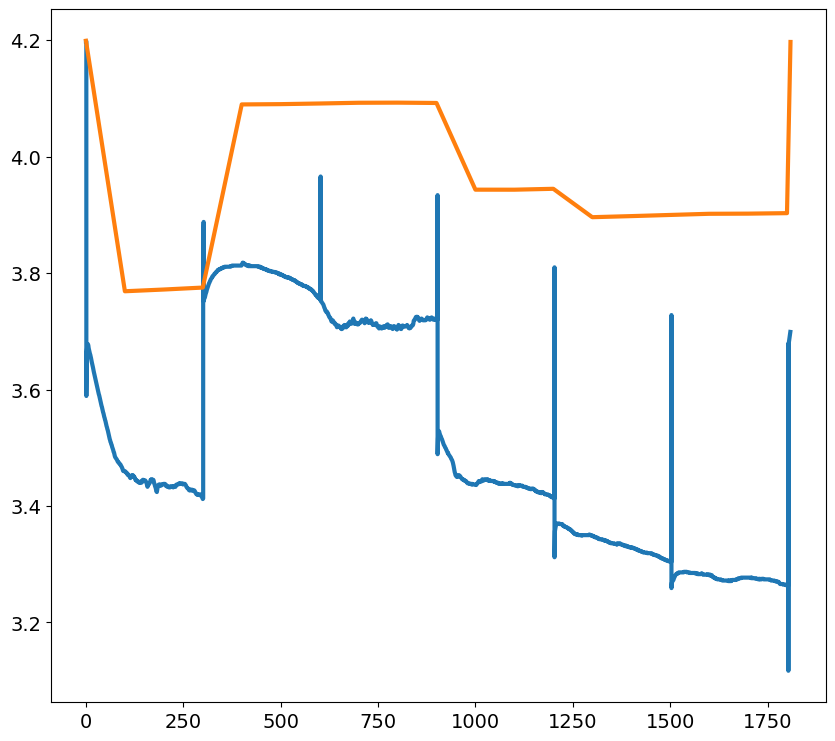

In [117]:
result_guess = m.simulate_to(random_walk_dataset['absoluteTime'].iloc[-1], future_load_rw, dt=1, save_freq=100)
plt.plot(times_rw, [z for z in random_walk_dataset['voltage']])
plt.plot(result_guess.times, [z['v'] for z in result_guess.outputs])

Much better, but not there yet. Next we need to use the parameter estimation feature to estimate the parameters further. First lets prepare some data. We'll use the reference dataset and the step run for this. 

In [ ]:
times_ref = reference_dataset['relativeTime']
inputs_ref = [{'P': elem[1]['voltage'] * elem[1]['current']} for elem in reference_dataset.iterrows()]
outputs_ref = [{'v': elem[1]['voltage']} for elem in reference_dataset.iterrows()]

times_step = step_dataset['relativeTime']
inputs_step = [{'P': elem[1]['voltage'] * elem[1]['current']} for elem in step_dataset.iterrows()]
outputs_step = [{'v': elem[1]['voltage']} for elem in step_dataset.iterrows()]

Now we are going to print the keys and the error beforehand for reference. The error here is what is used to estimate parameters.

In [140]:
inputs_reformatted_rw = [{'P': elem[1]['voltage'] * elem[1]['current']} for elem in random_walk_dataset.iterrows()]
all_keys = ['v_L', 'R_int', 'lambda', 'gamma', 'mu', 'beta', 'E_crit']
print('Model configuration')
for key in all_keys:
    print("-", key, m[key])
error_guess = m.calc_error(times=times_rw.to_list(), inputs=inputs_reformatted_rw, outputs=outputs_rw)
print('Error: ', error_guess)


Model configuration
- v_L 4.2
- R_int 0.117215
- lambda 0.046
- gamma 3.355
- mu 2.759
- beta 8.482
- E_crit 50606.7145
Error:  0.21202709874157225


Next, lets set the bounds on each of the parameters.

For v_L and R_int, we're defining some small bounds because we have an idea of what they might be. For the others we are saying it's between 0.1 and 10x the default battery. We also are adding a constraint that E_crit must be smaller than the default, since we know it's a smaller battery.

In [141]:
bounds= {
    'v_L': (3.75, 4.5),
    'R_int': (batt['Ro']*0.5, batt['Ro']*2.5),
    'lambda': (0.046/10, 0.046*10),
    'gamma': (3.355/10, 3.355*10),
    'mu': (2.759/10, 2.759*10),
    'beta': (8.482/10, 8.482*10),
    'E_crit': (202426.858/10, 202426.858) # (smaller than default)
}

Finally, we'll estimate the parameters. See [Param Estimation](https://nasa.github.io/progpy/prog_models_guide.html#parameter-estimation) for more details

In [142]:
times_trickle = trickle_dataset['relativeTime']
inputs_trickle = [{'P': elem[1]['voltage'] * elem[1]['current']} for elem in trickle_dataset.iterrows()]
outputs_trickle = [{'v': elem[1]['voltage']} for elem in trickle_dataset.iterrows()]

keys = ['v_L']
m.estimate_params(times=trickle_dataset['relativeTime'].iloc[:10].to_list(), inputs=inputs_trickle[:10], outputs=outputs_trickle[:10], keys=keys, dt=1, bounds=bounds)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 9.254842942840593e-07
             x: [ 4.196e+00]
           nit: 13
          nfev: 26
 final_simplex: (array([[ 4.196e+00],
                       [ 4.196e+00]]), array([ 9.255e-07,  9.271e-07]))

Model configuration
- v_L 4.19564208984375
- R_int 0.117215
- lambda 0.046
- gamma 3.355
- mu 2.759
- beta 8.482
- E_crit 50606.7145
Error: 0.21202709874157225->0.2079383423402638 (-0.004088756401308458)


(0.0, 0.25)

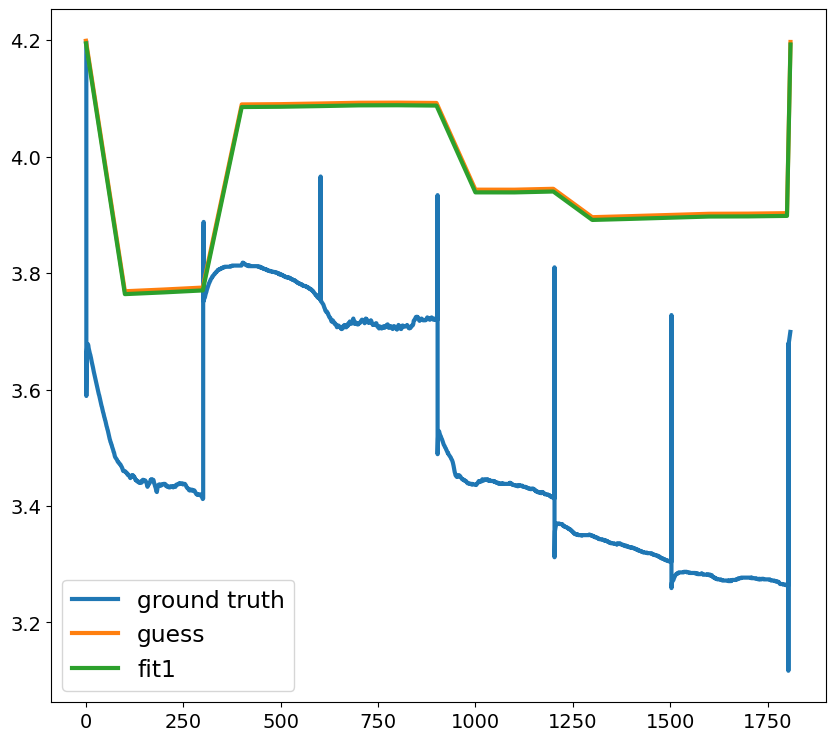

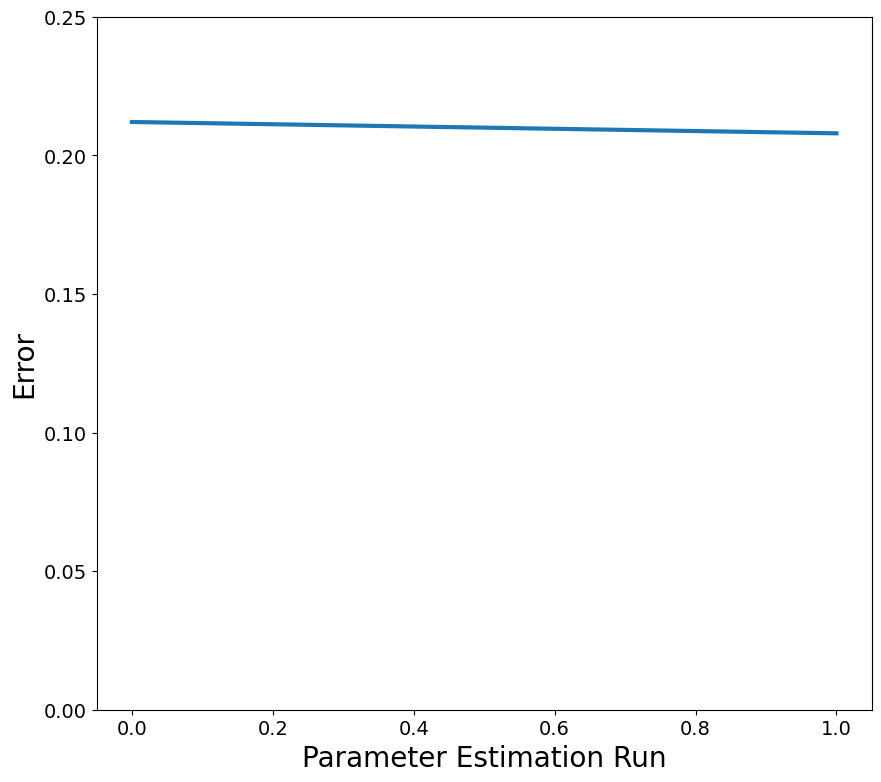

In [143]:
print('Model configuration')
for key in all_keys:
    print("-", key, m[key])
error_fit1 = m.calc_error(times=times_rw.to_list(), inputs=inputs_reformatted_rw, outputs=outputs_rw)
print(f'Error: {error_guess}->{error_fit1} ({error_fit1-error_guess})')

result_fit1 = m.simulate_to(random_walk_dataset['absoluteTime'].iloc[-1], future_load_rw, dt=1, save_freq=100)
plt.plot(times_rw, [z for z in random_walk_dataset['voltage']], label='ground truth')
plt.plot(result_guess.times, [z['v'] for z in result_guess.outputs], label='guess')
plt.plot(result_fit1.times, [z['v'] for z in result_fit1.outputs], label='fit1')
plt.legend()

plt.figure()
plt.plot([0, 1], [error_guess, error_fit1])
plt.xlabel('Parameter Estimation Run')
plt.ylabel('Error')
plt.ylim((0, 0.25))

In [148]:
keys = ['R_int']
m.estimate_params(times=[times_ref.iloc[:5].to_list(), times_step.iloc[:5].to_list()], inputs=[inputs_ref[:5], inputs_step[:5]], outputs=[outputs_ref[:5], outputs_step[:5]], keys=keys, dt=1, bounds=bounds)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.006025562076090138
             x: [ 5.861e-02]
           nit: 5
          nfev: 10
 final_simplex: (array([[ 5.861e-02],
                       [ 5.861e-02]]), array([ 6.026e-03,  6.026e-03]))

Model configuration
- v_L 4.19564208984375
- R_int 0.17234267968750006
- lambda 0.046
- gamma 3.355
- mu 2.759
- beta 8.482
- E_crit 50606.7145
Error: 0.2079383423402638->0.11180908524941818 (-0.0961292570908456)


(0.0, 0.25)

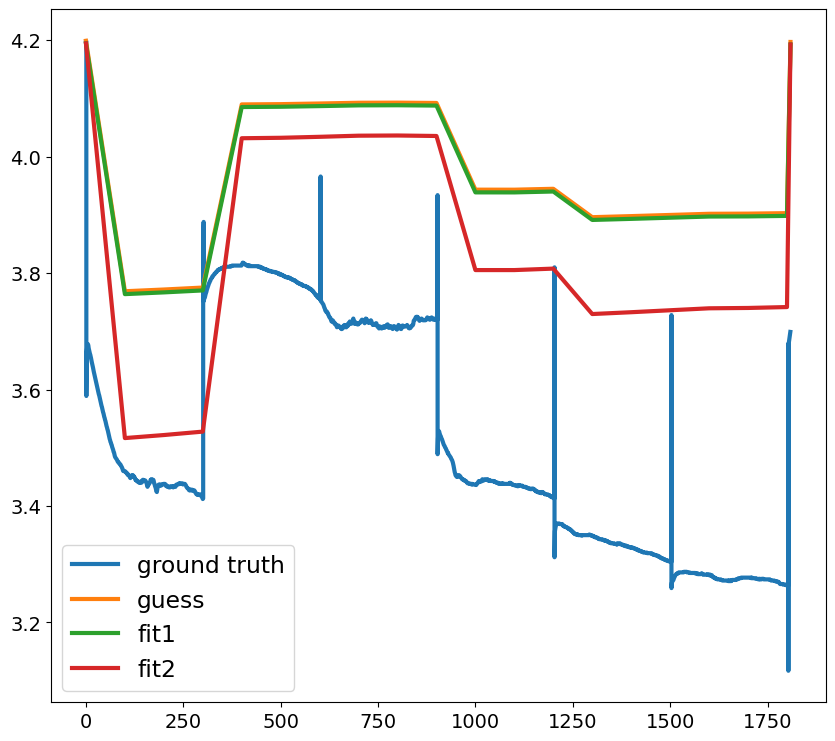

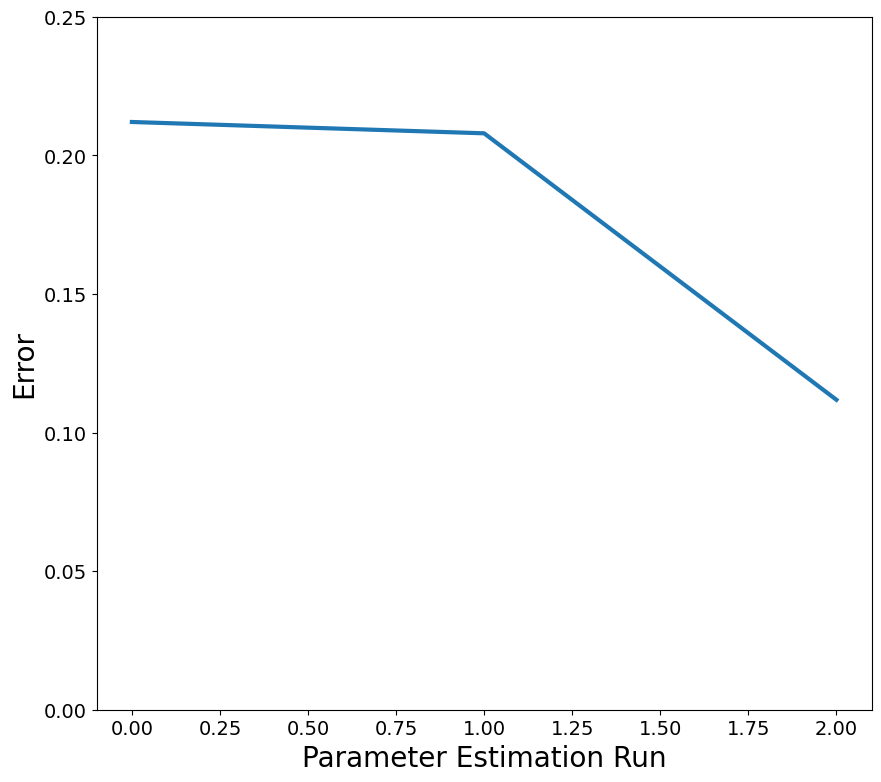

In [145]:
print('Model configuration')
for key in all_keys:
    print("-", key, m[key])
error_fit2 = m.calc_error(times=times_rw.to_list(), inputs=inputs_reformatted_rw, outputs=outputs_rw)
print(f'Error: {error_fit1}->{error_fit2} ({error_fit2-error_fit1})')

result_fit2 = m.simulate_to(random_walk_dataset['absoluteTime'].iloc[-1], future_load_rw, dt=1, save_freq=100)
plt.plot(times_rw, [z for z in random_walk_dataset['voltage']], label='ground truth')
plt.plot(result_guess.times, [z['v'] for z in result_guess.outputs], label='guess')
plt.plot(result_fit1.times, [z['v'] for z in result_fit1.outputs], label='fit1')
plt.plot(result_fit2.times, [z['v'] for z in result_fit2.outputs], label='fit2')
plt.legend()

plt.figure()
plt.plot([0, 1, 2], [error_guess, error_fit1, error_fit2])
plt.xlabel('Parameter Estimation Run')
plt.ylabel('Error')
plt.ylim((0, 0.25))

In [150]:
keys = ['lambda', 'gamma', 'mu', 'beta', 'E_crit']
m.estimate_params(times=times_ref.to_list(), inputs=inputs_ref, outputs=outputs_ref, keys=keys, dt=1, bounds=bounds)

/Users/cteubert/dev/progpy/src/progpy/prognostics_model.py:1419: UserWarning: Parameter Estimation did not converge: Maximum number of function evaluations has been exceeded.
  warn(f"Parameter Estimation did not converge: {res.message}")


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.0020902805415891094
             x: [ 2.138e-02  3.455e-01  3.202e-01  1.605e+01  3.196e+04]
           nit: 615
          nfev: 1000
 final_simplex: (array([[ 2.138e-02,  3.455e-01, ...,  1.605e+01,
                         3.196e+04],
                       [ 2.137e-02,  3.455e-01, ...,  1.605e+01,
                         3.196e+04],
                       ...,
                       [ 2.140e-02,  3.456e-01, ...,  1.604e+01,
                         3.196e+04],
                       [ 2.140e-02,  3.456e-01, ...,  1.605e+01,
                         3.196e+04]]), array([ 2.090e-03,  2.090e-03,  2.090e-03,  2.090e-03,
                        2.090e-03,  2.090e-03]))

Model configuration
- v_L 4.19564208984375
- R_int 0.0586075
- lambda 0.021377769962193927
- gamma 0.3455107027659521
- mu 0.3202499791110093
- beta 16.04797764623227
- E_crit 31961.079589421366
Error: 0.11180908524941818->0.04750641376260599 (-0.0643026714868122)


(0.0, 0.25)

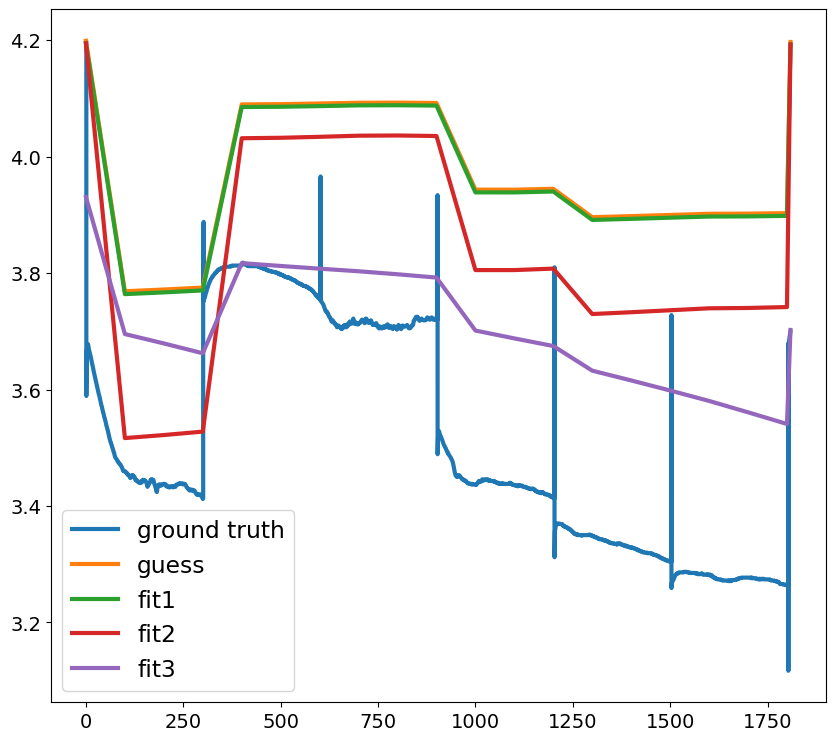

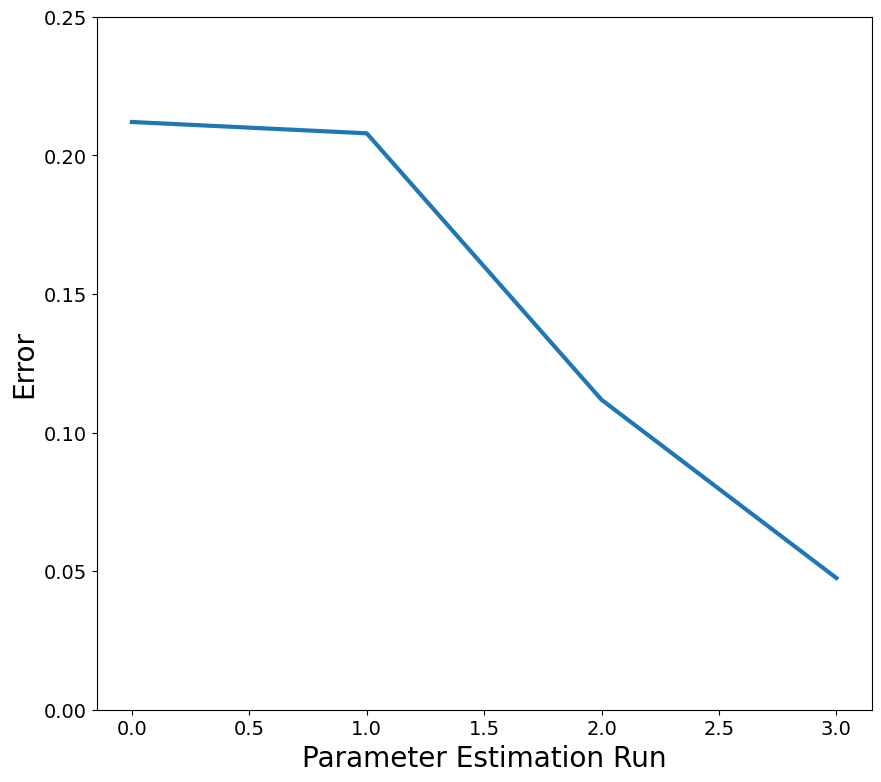

In [151]:
print('Model configuration')
for key in all_keys:
    print("-", key, m[key])
error_fit3 = m.calc_error(times=times_rw.to_list(), inputs=inputs_reformatted_rw, outputs=outputs_rw)
print(f'Error: {error_fit2}->{error_fit3} ({error_fit3-error_fit2})')

result_fit3 = m.simulate_to(random_walk_dataset['absoluteTime'].iloc[-1], future_load_rw, dt=1, save_freq=100)
plt.plot(times_rw, [z for z in random_walk_dataset['voltage']], label='ground truth')
plt.plot(result_guess.times, [z['v'] for z in result_guess.outputs], label='guess')
plt.plot(result_fit1.times, [z['v'] for z in result_fit1.outputs], label='fit1')
plt.plot(result_fit2.times, [z['v'] for z in result_fit2.outputs], label='fit2')
plt.plot(result_fit3.times, [z['v'] for z in result_fit3.outputs], label='fit3')
plt.legend()

plt.figure()
plt.plot([0, 1, 2, 3], [error_guess, error_fit1, error_fit2, error_fit3])
plt.xlabel('Parameter Estimation Run')
plt.ylabel('Error')
plt.ylim((0, 0.25))

In [ ]:
keys = ['mu', 'beta']
m.estimate_params(times=times_step.to_list(), inputs=inputs_step, outputs=outputs_step, keys=keys, dt=1, bounds=bounds)

In [87]:
times_trickle = trickle_dataset['relativeTime']
inputs_trickle = [{'P': elem[1]['voltage'] * elem[1]['current']} for elem in trickle_dataset.iterrows()]
outputs_trickle = [{'v': elem[1]['voltage']} for elem in trickle_dataset.iterrows()]

keys = ['v_L', 'R_int', 'lambda', 'gamma', 'mu', 'beta', 'E_crit']
m.estimate_params(times=times_ref.to_list(), inputs=inputs_ref, outputs=outputs_ref, keys=keys, dt=1, bounds=bounds)

keys = ['mu', 'beta']
m.estimate_params(times=times_step.to_list(), inputs=inputs_step, outputs=outputs_step, keys=keys, dt=1, bounds=bounds)

/Users/cteubert/dev/progpy/src/progpy/prognostics_model.py:1419: UserWarning: Parameter Estimation did not converge: Maximum number of function evaluations has been exceeded.
  warn(f"Parameter Estimation did not converge: {res.message}")


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0320052462066305
             x: [ 2.759e+01  4.114e+00]
           nit: 135
          nfev: 246
 final_simplex: (array([[ 2.759e+01,  4.114e+00],
                       [ 2.759e+01,  4.114e+00],
                       [ 2.759e+01,  4.114e+00]]), array([ 3.201e-02,  3.201e-02,  3.201e-02]))

In [92]:
keys = ['v_L', 'R_int', 'lambda', 'gamma', 'mu', 'beta', 'E_crit']
for key in keys:
    print("-", key, m[key])
print('Error: ', m.calc_error(times=times_rw.to_list(), inputs=inputs_reformatted_rw, outputs=outputs_rw))

- v_L 4.498686849520917
- R_int 0.0586075
- lambda 0.3825366415734386
- gamma 1.6064697858687982
- mu 27.59
- beta 4.11437637865704
- E_crit 62130.08230654329
Error:  0.007435475999340515


ValueError: math domain error

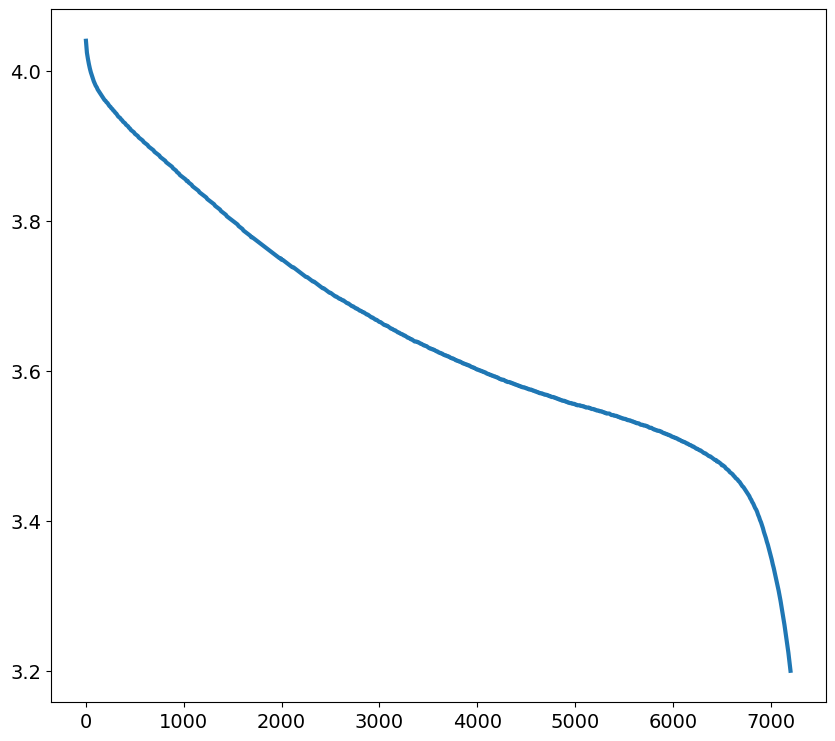

In [113]:
inputs_ref_loading = [elem[1]['voltage'] * elem[1]['current'] for elem in reference_dataset.iterrows()]
def future_load_ref(t, x=None):
    power = np.interp(t, times_ref, inputs_ref_loading)
    return {'P': power}

result = m.simulate_to(reference_dataset['relativeTime'].iloc[-1], future_load_ref, dt=1, save_freq=100)
plt.plot(reference_dataset['relativeTime'], [z for z in reference_dataset['voltage']])
plt.plot(result.times, [z['v'] for z in result.outputs])
fig = result.event_states.plot()

inputs_step_loading = [elem[1]['voltage'] * elem[1]['current'] for elem in step_dataset.iterrows()]
def future_load_step(t, x=None):
    power = np.interp(t, step_dataset['absoluteTime'], inputs_step_loading)
    return {'P': power}

result = m.simulate_to(step_dataset['absoluteTime'].iloc[-1], future_load_step, dt=1, save_freq=100)
plt.figure()
plt.plot(step_dataset['absoluteTime'], [z for z in step_dataset['voltage']])
plt.plot(result.times, [z['v'] for z in result.outputs])
fig = result.event_states.plot()

ValueError: math domain error

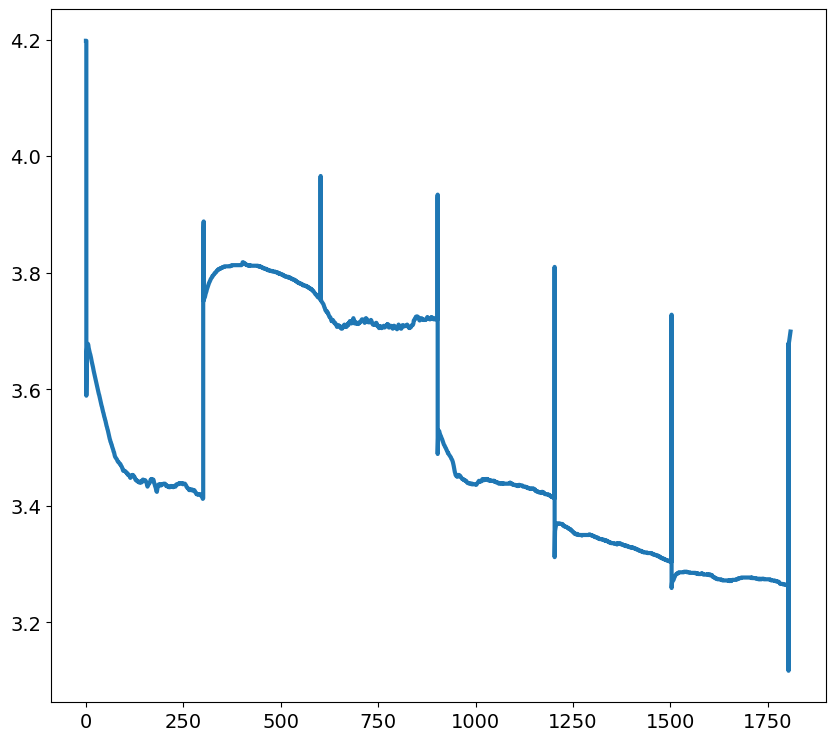

In [114]:
result = m.simulate_to(random_walk_dataset['absoluteTime'].iloc[-1], future_load_rw, dt=1, save_freq=100)
plt.plot(times_rw, [z for z in random_walk_dataset['voltage']])
plt.plot(result.times, [z['v'] for z in result.outputs])
fig = result.event_states.plot()

## Prognostics Example
Repeating above example

## Final Notes on Building New Models

todo: use tuple for est params

note: Extending model- ecrit and r as states

# Advanced Capabilities

## Combination Models

https://nasa.github.io/progpy/prog_models_guide.html#combination-models

This section demonstrates how prognostic models can be combined. There are two times in which this is useful: 

1. When combining multiple models of different inter-related systems into one system-of-system model (i.e., [Composite Models](https://nasa.github.io/progpy/api_ref/prog_models/CompositeModel.html)), or
2. Combining multiple models of the same system to be simulated together and aggregated (i.e., [Ensemble Models](https://nasa.github.io/progpy/api_ref/prog_models/EnsembleModel.html) or [Mixture of Expert Models](https://nasa.github.io/progpy/api_ref/progpy/MixtureOfExperts.html)). This is generally done to improve the accuracy of prediction when you have multiple models that each represent part of the behavior or represent a distribution of different behaviors.

For this example we will combine the competing models using a Mixture of Expert Model

## Closing

https://nasa.github.io/progpy/index.html#contributing-and-partnering